In [1]:
import keras
import numpy as np
from numpy.fft import fft,fftfreq,ifft

from keras import layers
from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import SGD
import keras.backend as K

from keras.layers import BatchNormalization                       
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import time

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pickle
import pandas as pd


np.random.seed(1)

%matplotlib inline

ImportError: cannot import name 'plot_model' from 'keras.utils' (C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\utils\__init__.py)

In [2]:
bases=2
data=np.zeros([648*bases,8,30])
(n_data,c,vpm)=data.shape
canales=[1,2,3,5,6,7,8]
data_y=np.zeros(648*bases)
data_y[0:648]=np.ones(648)
inicio=["V","F","F"]

In [3]:
for pre in range(0,bases):
    for j in range(0,8):
        nom=inicio[pre]+"_C"+str(j+1)+".csv"
        canal_csv=pd.read_csv(nom,header=None)
        canal=canal_csv.to_numpy()
        for i in range(0,30):
            data[648*pre:648*(pre+1),j,i]=canal[i]     

In [4]:
test_ratio = 0.1
n_data=648*bases
vpm=30

train_ratio = int((1.0-test_ratio)*n_data)

sample_idx = np.random.choice(len(data), size=len(data))
data_ = data[sample_idx]
data_y_ = data_y[sample_idx]

x_train = data_[0:train_ratio]
x_test  = data_[train_ratio:]

y_train=data_y_[0:train_ratio]
y_test=data_y_[train_ratio:]


train_y = y_train.reshape(-1,)
test_y = y_test.reshape(-1,)

train_x = x_train.reshape(-1,8,vpm,1)
test_x = x_test.reshape(-1,8,vpm,1)

In [5]:
def architecture(input_shape, num_classes, activation, dropout=True, batch_normalization=True):
    
    model = Sequential()
    
    model.add(Conv2D(32, 7, padding='same', input_shape=input_shape))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())

    model.add(Conv2D(32, 3, padding='valid', input_shape=input_shape))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    model.add(Conv2D(32, 3, padding='same', input_shape=(3,0.5*(vpm-2),1)))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())
        
    model.add(Conv2D(32, 3, padding='valid', input_shape=(3,0.5*(vpm-2),1)))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization()) 
        
    model.add(Flatten())
    if dropout:
        model.add(Dropout(0.30))
    
    model.add(Dense(50, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))    
    if batch_normalization:
        model.add(BatchNormalization())  
    if dropout:
        model.add(Dropout(0.30))
        
    model.add(Dense(50, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation('relu'))    
    if batch_normalization:
        model.add(BatchNormalization())  
    if dropout:
        model.add(Dropout(0.30))
        
    model.add(Dense(num_classes,kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Activation(activation,name='CNN_EEGModel'))
    
    return model

In [6]:
one_image = (8, 30,1)
activation='sigmoid'
num_classes=1
dropout=False
batch_normalization=False

model = architecture(one_image,num_classes,activation,dropout,batch_normalization)

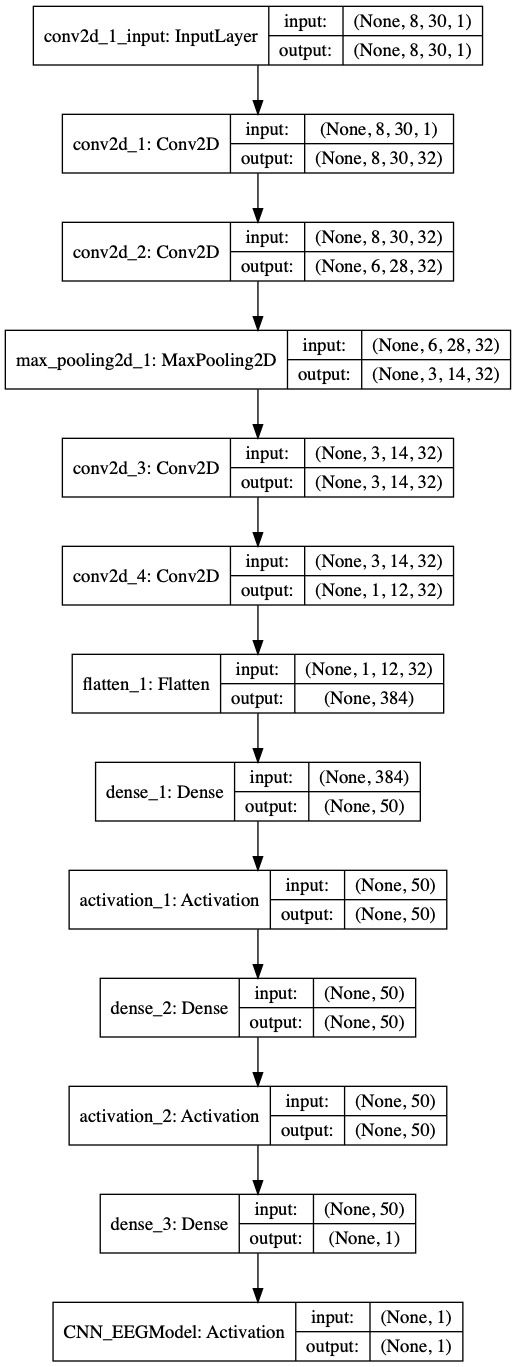

In [7]:
plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', show_layer_names=True)

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 30, 32)         1600      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 28, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 14, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 14, 32)         9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 12, 32)         9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)               

In [9]:
learning_rate = 0.001

#optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=False)
optimizer= keras.optimizers.adam(lr=learning_rate)

In [10]:
loss_function = 'binary_crossentropy'
metric_function = 'binary_accuracy'

In [11]:
model.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', outputLabels, outputs) 
classWeight = dict(enumerate(classWeight))

In [12]:
validation_portion = 0.1
num_epochs =30

history = model.fit(x = train_x, y = train_y, epochs = num_epochs, batch_size = 64, \
                            validation_split = validation_portion, shuffle=True, verbose=1)

Train on 1049 samples, validate on 117 samples
Epoch 1/30
1049/1049 [==============================] - 13s 12ms/step - loss: 0.5405 - binary_accuracy: 0.7464 - val_loss: 0.3379 - val_binary_accuracy: 0.8632
Epoch 2/30
1049/1049 [==============================] - 1s 1ms/step - loss: 0.2554 - binary_accuracy: 0.9133 - val_loss: 0.1901 - val_binary_accuracy: 0.9487
Epoch 3/30
1049/1049 [==============================] - 1s 1ms/step - loss: 0.1856 - binary_accuracy: 0.9390 - val_loss: 0.1976 - val_binary_accuracy: 0.9316
Epoch 4/30
1049/1049 [==============================] - 1s 1ms/step - loss: 0.1679 - binary_accuracy: 0.9466 - val_loss: 0.1682 - val_binary_accuracy: 0.9402
Epoch 5/30
1049/1049 [==============================] - 2s 2ms/step - loss: 0.1324 - binary_accuracy: 0.9552 - val_loss: 0.1467 - val_binary_accuracy: 0.9573
Epoch 6/30
1049/1049 [==============================] - 1s 1ms/step - loss: 0.1069 - binary_accuracy: 0.9695 - val_loss: 0.1667 - val_binary_accuracy: 0.9487
Epo

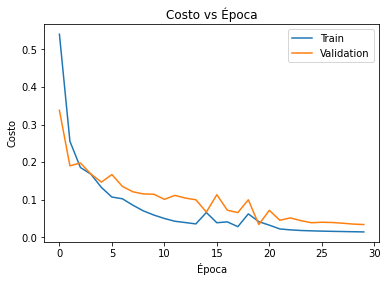

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Costo vs Época')
#plt.xlim(0,50)
plt.ylabel('Costo')
plt.xlabel('Época')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("CvsE.png")
plt.show()

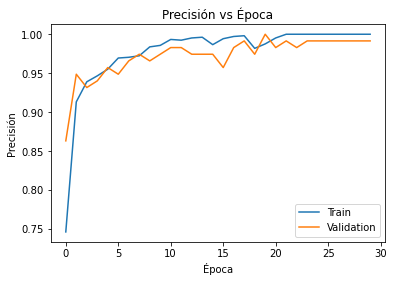

In [14]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Precisión vs Época')
plt.ylabel('Precisión')
#plt.xlim(0,50)
plt.xlabel('Época')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig("Accuracy.png")
plt.show()

In [15]:
arr=history.history['val_binary_accuracy']
result = np.where(arr == np.amax(arr))
print(result)

(array([19]),)


In [16]:
print(np.amax(arr))

1.0


In [17]:
loss,accuracy = model.evaluate(test_x,test_y,batch_size = 32,verbose = 1)
print("Test fraction correct (Accuracy) = {:.2f}".format(accuracy))

130/130 [==============================] - 0s 681us/step
Test fraction correct (Accuracy) = 0.99


In [18]:
res=model.predict(test_x)

In [19]:
contador=0
corte=0.5
pred_y=np.zeros(len(res))
for i in range(0,len(test_x)):
    if res[i]>corte:
        if test_y[i]==1.0:
            contador+=1
        pred_y[i]=1.0
    if res[i]<=corte:
        if test_y[i]==0.0:
            contador+=1

In [20]:
contador/len(test_y)

0.9923076923076923

In [21]:
mask_t=test_y==1
mask_f=test_y==0

In [22]:
cm=confusion_matrix(test_y, pred_y,labels=[1,0])

In [23]:
cm_norm=100*cm/(np.sum(cm))

In [24]:
import itertools

In [33]:
def plot_confusion_matrix(cm, classes,title='Matriz de confusión',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print('Confusion matrix')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2))+"%",
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.savefig("Conf_mat.png",dpi=400)

In [31]:
cm_plot_labels = ['Onda p300','Actividad normal']

Confusion matrix


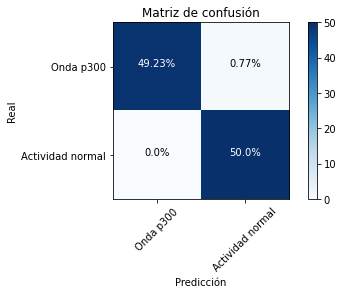

In [34]:
plot_confusion_matrix(cm=cm_norm, classes=cm_plot_labels)

In [28]:
def val_pred(cm):
    print("Sensibilidad="+str(cm[0,0]/(cm[0,0]+cm[0,1])))
    print("Especificidad="+str(cm[1,1]/(cm[1,1]+cm[1,0])))
    print("Valor predictivo positivo="+str(cm[0,0]/(cm[0,0]+cm[1,0])))
    print("Valor predictivo negativo="+str(cm[1,1]/(cm[1,1]+cm[0,1])))

In [29]:
val_pred(cm)

Sensibilidad=0.9846153846153847
Especificidad=1.0
Valor predictivo positivo=1.0
Valor predictivo negativo=0.9848484848484849


In [49]:
from sklearn.metrics import roc_curve,plot_roc_curve,auc

In [50]:
fpr, tpr, thresholds=roc_curve(test_y, pred_y)

In [51]:
roc_auc=auc(fpr,tpr)

In [41]:
sen=cm[0,0]/(cm[0,0]+cm[0,1])
esp=cm[1,1]/(cm[1,1]+cm[1,0])

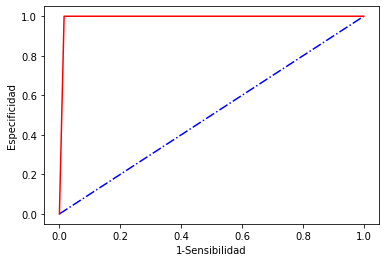

In [48]:
plt.plot([0,1],[0,1],'-.b')
plt.plot([0,1-sen,1],[0,esp,1],'r')
plt.xlabel("1-Sensibilidad")
plt.ylabel("Especificidad")
plt.savefig("ROC.png")
plt.show;